Module Project 보고서 목차

1) 목표(주제)
2) 조원 소개 및 역할
3) 프로젝트 진행
   ① 데이터 수집
   ② 시각화
   ③ 전처리
   ④ 분석
   ⑤ 예측
4) 결과 및 보완점
5) 후기

# <Module Project 보고서>


# 1. 프로젝트 주제
: 치킨 배달 주문 건수와 날씨/축구 경기와의 상관관계 분석(2017년 1월 ~ 19년 9월)

# 2. 조원 소개 및 역할
- 최민창:
- 권윤옥:


# 3. 프로젝트 진행
## 3-1. 데이터 수집
###  ① 데이터 출처
 - SK BIGDATA HUB: https://www.bigdatahub.co.kr/index.do
 - 기상청 기상자료개방포털: https://data.kma.go.kr/cmmn/main.do
 - 네이버 스포츠: https://sports.news.naver.com/kfootball/schedule/index.nhn?category=amatch

###  ② 데이터 수집 및 가공
- **서울시 치킨 판매업종 이용 통화량 데이터**

: 월별로 제공되는 csv파일을 읽어서 DataFrame으로 합친 뒤 OrcleDB에 저장

- **필요한 라이브러리 Import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Oracle DB 접속 관련 라이브러리
import cx_Oracle
import os

# 네이버 크롤링에 사용한 라이브러리
from selenium import webdriver as wd
import requests
import time
import datetime

# 데이터 시각화에 필요한 라이브러리
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
from pandas.api.types import CategoricalDtype

# 의사결정트리 제작에 필요한 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pydotplus

In [2]:
chickenCall = pd.read_csv("c:/ai/workspace/module_project02/201701-201909/2017_CALL_CHICKEN_01MONTH.csv")

In [4]:
# 2017/01 월 ~ 2019/09월 까지의 데이터를 for문을 통해 반복적으로 읽어서 chickenCall 데이터프레임에 추가
ZERO=str(0)

for y in range(2017, 2020):
    for m in range(1, 13):
        if (y==2017) & (m==1):
            continue;
        if m < 10:
            tmp_df = pd.read_csv("c:/ai/workspace/module_project02/201701-201909/" +str(y)+ "_CALL_CHICKEN_" +ZERO+str(m)+ "MONTH.csv")
        elif (y==2019) & (m==10):
            break;
        else:
            tmp_df = pd.read_csv("c:/ai/workspace/module_project02/201701-201909/" +str(y)+ "_CALL_CHICKEN_" +str(m)+ "MONTH.csv")

        chickenCall=chickenCall.append(tmp_df)

In [6]:
# 기준일 컬럼 데이터 형식:int64 > date형으로 변환
chickenCall['기준일'] = pd.to_datetime(chickenCall['기준일'].astype(str), format="%Y%m%d")

In [7]:
chickenCall.head()

,기준일,요일,성별,연령대,시도,시군구,읍면동,업종,통화건수
0,2017-01-01,일,남,40대,서울특별시,강남구,개포동,치킨,9
1,2017-01-01,일,남,60대이상,서울특별시,강남구,세곡동,치킨,5
2,2017-01-01,일,여,40대,서울특별시,강남구,역삼동,치킨,36
3,2017-01-01,일,여,40대,서울특별시,강남구,일원동,치킨,12
4,2017-01-01,일,여,40대,서울특별시,강남구,도곡동,치킨,17


In [8]:
# Oracle DB에 저장하기 위해 DataFrame > list 로 형변환
df_list = chickenCall.values.tolist()

In [10]:
# Oracle DB접속 정보
os.putenv('NLS_LANG', '.UTF8')

connection = cx_Oracle.connect('hr', 'hr', '192.168.99.100:1521/xe')

cursor = connection.cursor()

In [11]:
sql = 'insert into chicken_call values (:1, :2, :3, :4, :5, :6, :7, :8, :9)'

In [ ]:
# df_list를 Oracle_db에 저장
#for data in df_list:
#    cursor.execute(sql, data)

In [12]:
connection.commit()

- **일별 날씨 데이터**

: 날씨 체감에 영향을 미치는 요인은 평균기온, 강수량 이라고 판단하여 해당 정보만 선택하여 다운,
  해당 csv파일을 데이터프레임에 추가

In [13]:
weather_df=pd.read_csv("c:/ai/workspace/module_project02/weather/weather.csv")

In [15]:
weather_df.head()

,일시,평균기온(°C),일강수량(mm)
0,2017-01-01,2.7,0.0
1,2017-01-02,5.0,0.3
2,2017-01-03,2.0,0.0
3,2017-01-04,3.9,0.0
4,2017-01-05,3.8,0.0


- **축구경기 일정 데이터 크롤링**

In [16]:
url='https://sports.news.naver.com/kfootball/schedule/index.nhn?year=2017&category=amatch&month=1'

In [17]:
res=requests.get(url).text

In [18]:
driver=wd.Chrome("C:/ai/program/chromedriver.exe")

In [19]:
driver.implicitly_wait(10)
driver.get(url)

In [20]:
driver.find_element_by_css_selector("#_seasonListArea > button.btn_move_date.next").click()

In [21]:
selector = '#_monthlyScheduleList > tr'

In [22]:
trs = driver.find_elements_by_css_selector(selector)

In [23]:
kfootball_list=[]
for y in range(2017, 2021):    
    selector = '#_monthlyScheduleList > tr'
    trs = driver.find_elements_by_css_selector(selector)
    for tr in trs:
        try:
            #date = tr.find_element_by_tag_name('th').text
            date = tr.find_element_by_tag_name('th').text.split(' ')[0]            
            yoil = tr.find_element_by_tag_name('th').text.split(' ')[1].replace("(","").replace(")","")            
            month = date.split('.')[0]
            
            if len(month) == 1:
                month = str(0)+month
            day = date.split('.')[1]
            if len(day) == 1:
                day = str(0)+day
            #print("month, day, yoil:", month, day, yoil)
            
        except Exception as ex:
            #print("th없음", ex)
            month =''
            day = ''
            yoil = ''
            
        tds = tr.find_elements_by_tag_name('td')    
                
        time_place=tds[0].text
        sigan=time_place[0:5]
        #print(sigan)
        
        country=tds[1].text
        #print(country)
        country=country.replace("\n", ' ')
        #country_list=country.split("대한민국")
        
        label=tds[3].text
        #print(label)
        yeardate=str(y)+month+day        
        
        kfootball_list.append([yeardate,yoil,sigan,country,label])
        #print("="*50)
        
    driver.find_element_by_css_selector("#_seasonListArea > button.btn_move_date.next").click()
    time.sleep(3)
    
#print(kfootball_list)

In [24]:
with open("kfootball_list.csv","w") as file:
    file.write("yeardate,yoil,sigan,country,label\n")
    for i in kfootball_list:
        file.write('{0},{1},{2},{3},{4}\n'.format(i[0],i[1],i[2],i[3],i[4]))

- 크롤링 데이터 정형화

In [26]:
df= pd.read_csv("c:/ai/workspace/module_project02/kfootball_list.csv", encoding='CP949')
df.head()

,yeardate,yoil,sigan,country,label
0,20170111,목,20:30,대한민국 2 승리팀 베트남 1,국가대표
1,20170114,일,20:30,대한민국 0 시리아 0,국가대표
2,20170117,수,20:30,대한민국 3 승리팀 호주 2,국가대표
3,20170120,토,17:00,대한민국 2 승리팀 말레이시아 1,국가대표
4,20170123,화,20:30,대한민국 1 우즈베키스탄 4 승리팀,국가대표


In [27]:
#데이터프레임[컬럼].loc[인덱스] 를 입력하면 해당 인덱스의 데이터 리턴 
df["yeardate"].loc[74]

20181015

In [28]:
#날짜 전처리 함수
#index: 데이터의 인덱스가 순서대로 대입
def yeardate_process(index):
    #index번째 데이터를 문자열로 변환해서 date_data에 대입
    date_data=str(df["yeardate"].loc[index])
    #글자수가 8 미만이면
    if len(date_data)<8:
        #한줄위의 데이터를 리턴
        return df["yeardate"].loc[index-1]
    else:
        #데이터를 리턴
        return df["yeardate"].loc[index]

In [30]:
#df[year_date]의 각 인덱스를 순서대로 yeardate_process함수에 대입하고 리턴한 값들을
#df["yeardate"] 컬럼에 대입
df["yeardate"]=df["yeardate"].index.map(yeardate_process)

In [31]:
#yoil컬럼의 Nan을 삭제
df["yoil"].fillna("", inplace=True)

In [32]:
#요일을 처리하는 함수
def yoil_process(index):
    #yoil의 index번째 데이터 리턴
    yoil_data=df["yoil"].loc[index]
    #글자수가 0이면
    if len(yoil_data)==0:
        #하나위의 데이터 리턴
        return df["yoil"].loc[index-1]
    else:
        #데이터 리턴
        return df["yoil"].loc[index]    

In [33]:
df["yoil"]=df["yoil"].index.map(yoil_process)
df.head()

,yeardate,yoil,sigan,country,label
0,20170111,목,20:30,대한민국 2 승리팀 베트남 1,국가대표
1,20170114,일,20:30,대한민국 0 시리아 0,국가대표
2,20170117,수,20:30,대한민국 3 승리팀 호주 2,국가대표
3,20170120,토,17:00,대한민국 2 승리팀 말레이시아 1,국가대표
4,20170123,화,20:30,대한민국 1 우즈베키스탄 4 승리팀,국가대표


In [34]:
df.to_csv('C:/ai/workspace/module_project02/kfootball_plan.csv',
           sep=',',
           index=False
           )

## 3-2. 데이터 시각화

Oracle DB에 저장된 파일을 읽어와서 데이터 시각화하기

In [35]:
os.putenv('NLS_LANG', '.UTF8')

connection = cx_Oracle.connect('hr', 'hr', '192.168.99.100:1521/xe')

cursor = connection.cursor()

In [111]:
chCall_df = pd.read_sql("select * from chicken_call", connection)

In [112]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,SIDO,GU,DONG,JOB,CALLCNT
0,2017-01-01,일,여,50대,서울특별시,강북구,미아동,치킨,28
1,2017-01-01,일,여,20대,서울특별시,강북구,번동,치킨,8
2,2017-01-01,일,여,20대,서울특별시,강북구,미아동,치킨,49
3,2017-01-01,일,여,20대,서울특별시,강북구,수유동,치킨,5
4,2017-01-01,일,남,10대,서울특별시,강북구,번동,치킨,5


In [38]:
# 각 컬럼의 개수, 평균, 표준편차, 최소값등을 출력
chCall_df.describe()

,CALLCNT
count,1.124835e+06
mean,1.295132e+01
std,1.913560e+01
min,5.000000e+00
25%,5.000000e+00
50%,5.000000e+00
75%,1.200000e+01
max,4.580000e+02


In [39]:
chCall_df.isnull().sum()

CALLDATE     0
DAYOFWEEK    0
GENDER       0
AGE          0
SIDO         0
GU           0
DONG         0
JOB          0
CALLCNT      0
dtype: int64

In [113]:
#구와 동을 합쳐서 GU_DONG 컬럼 추가
chCall_df['GU_DONG'] = chCall_df['GU'] + ' ' + chCall_df['DONG']

In [41]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,SIDO,GU,DONG,JOB,CALLCNT,GU_DONG
0,2017-01-01,일,여,50대,서울특별시,강북구,미아동,치킨,28,강북구 미아동
1,2017-01-01,일,여,20대,서울특별시,강북구,번동,치킨,8,강북구 번동
2,2017-01-01,일,여,20대,서울특별시,강북구,미아동,치킨,49,강북구 미아동
3,2017-01-01,일,여,20대,서울특별시,강북구,수유동,치킨,5,강북구 수유동
4,2017-01-01,일,남,10대,서울특별시,강북구,번동,치킨,5,강북구 번동


### 3-2-1. 요일과 주문 건수와의 상관관계 파악하기

In [42]:
# 요일별로 그룹하여 합한 주문건수 데이터 조회
dow_s_df=chCall_df.groupby("DAYOFWEEK")["CALLCNT"].sum()
dow_s_df

DAYOFWEEK
금    2454285
목    1809545
수    1828043
월    1614700
일    2454727
토    2663442
화    1743359
Name: CALLCNT, dtype: int64

In [43]:
# 데이터 정렬을 위한 요일 list 생성
dayOfWeek=['월', '화', '수', '목', '금', '토', '일']

In [44]:
# 요일별 주문건수 합계 데이터를 요일 순으로 정렬
sort_df=dow_s_df.reindex(dayOfWeek)
sort_df

DAYOFWEEK
월    1614700
화    1743359
수    1828043
목    1809545
금    2454285
토    2663442
일    2454727
Name: CALLCNT, dtype: int64

In [45]:
# 시각화에 필요한 한글 폰트 가져오기
fl = fm.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=fl)

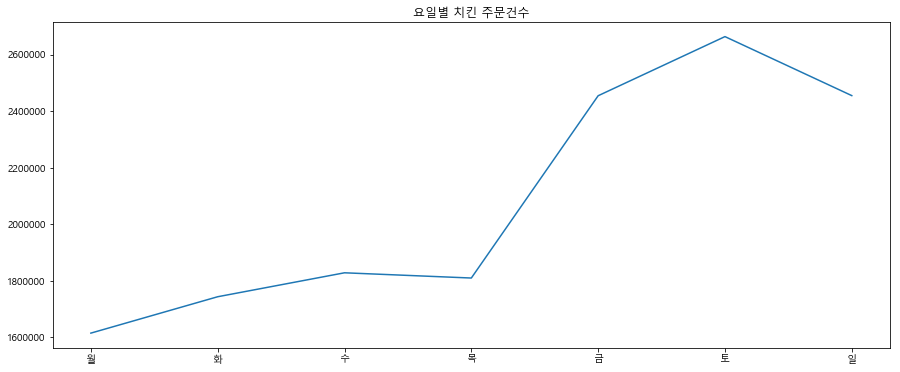

In [47]:
plt.figure(figsize=(15,6))
plt.title("요일별 치킨 주문건수")
plt.plot(sort_df)
plt.show()

In [48]:
#2019/9월 데이터 중에서 일별로 그룹해서 통화건수를 합함
sep = chCall_df[chCall_df['CALLDATE'] >= datetime.datetime(2019,9,1)].groupby("CALLDATE")["CALLCNT"].sum()

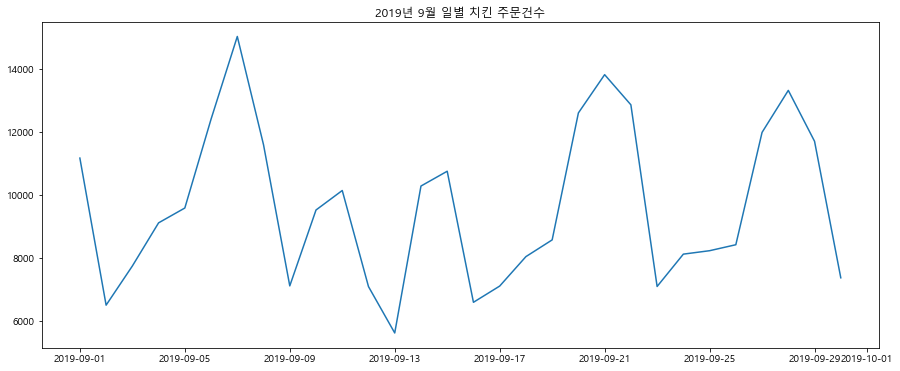

In [49]:
plt.figure(figsize=(15,6))
plt.title("2019년 9월 일별 치킨 주문건수")
plt.plot(sep)
plt.show()

- 요일별로 주문건수를 조회해본 결과 평일의 시작인 월요일에 주문이 가장 적으며, 주말에 주문이 증가하는 것을 확인할 수 있었음
- 월간 데이터로 조회했을 땐, 일주일 단위로 주기성을 띄고 있는 것을 확인함 (9/13일은 추석이라 예외적임)

### 3-2-2. 지역구와 주문건수와의 상관관계

In [50]:
# 구별 통화량 합계
gu_df = chCall_df.groupby(['GU'])['CALLCNT'].sum()
gu_df.head()

GU
강남구    1043986
강동구     591266
강북구     689198
강서구    1371408
관악구     914127
Name: CALLCNT, dtype: int64

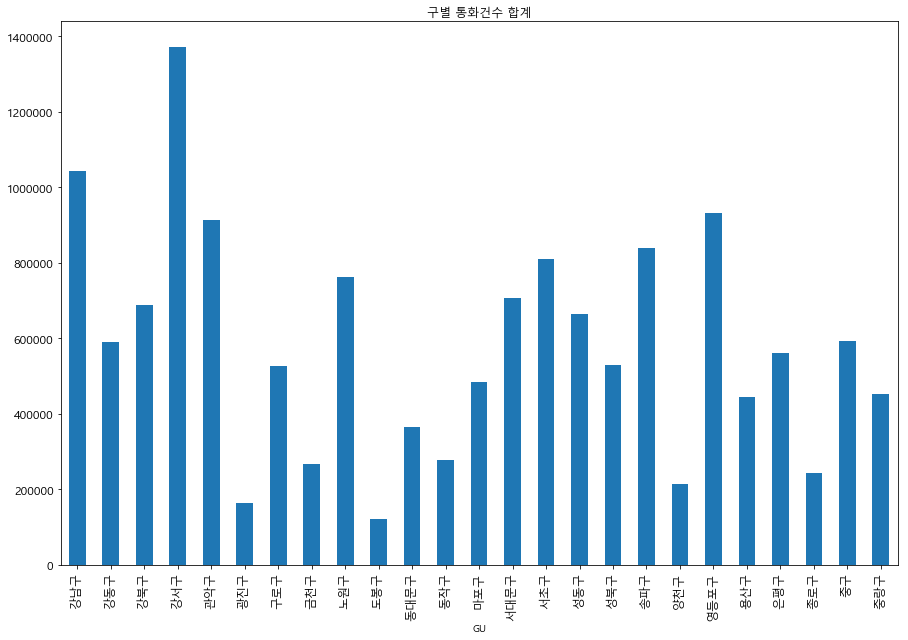

In [51]:
gu_df.plot(kind='bar', title='구별 통화건수 합계', figsize=(15,10), fontsize=12)

In [114]:
# 'CALLDATE'컬럼에서 년도와 월 정보만 출력하여 각각 'Y', 'M' 컬럼으로 추가
chCall_df['Y'] = chCall_df['CALLDATE'].dt.year
chCall_df['M'] = chCall_df['CALLDATE'].dt.month

In [53]:
# 년도, 월별, 지역구 별로 그룹하여 주문건수 합계를 구함
gu_m_sum = chCall_df.groupby(['Y', 'M', 'GU'], as_index=False).sum()
gu_m_sum.head()

,Y,M,GU,CALLCNT
0,2017,1,강남구,35568
1,2017,1,강동구,24532
2,2017,1,강북구,20118
3,2017,1,강서구,48100
4,2017,1,관악구,31492


Text(0.5, 1.0, '지역구별 월간 주문건수 Boxplot')

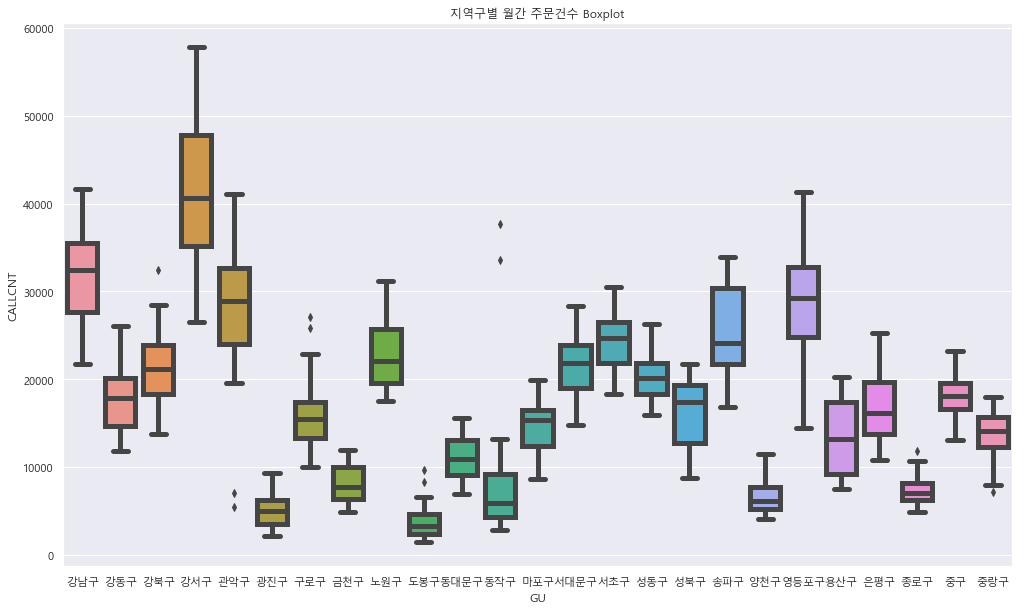

In [54]:
sns.set(rc={'figure.figsize':(17, 10)}, font=fl)
sns.boxplot( x=gu_m_sum['GU'], y=gu_m_sum['CALLCNT'], linewidth=5).set_title("지역구별 월간 주문건수 Boxplot")

- 구별로 주문건수를 조회하였더니 주거지가 많은 강서구, 강남구, 관악구 등이 주문량이 많은 것으로 파악됨
- 주거지 보다 번화가, 산이 많은 지형은 배달 주문이 적은 것을 확인할 수 있었음

### 3-2-3. 성별과 주문건수와의 상관 관계

In [55]:
# 년도, 월별, 성별, 지역구 별로 그룹하여 주문건수 합계 구함
gu_m_g_sum = chCall_df.groupby(['Y', 'M', 'GU', 'GENDER'], as_index=False).sum()
gu_m_g_sum.head()

,Y,M,GU,GENDER,CALLCNT
0,2017,1,강남구,남,16930
1,2017,1,강남구,여,18638
2,2017,1,강동구,남,11547
3,2017,1,강동구,여,12985
4,2017,1,강북구,남,8992


Text(0.5, 1.0, '지역구별 남/녀 월간 주문건수 Boxplot')

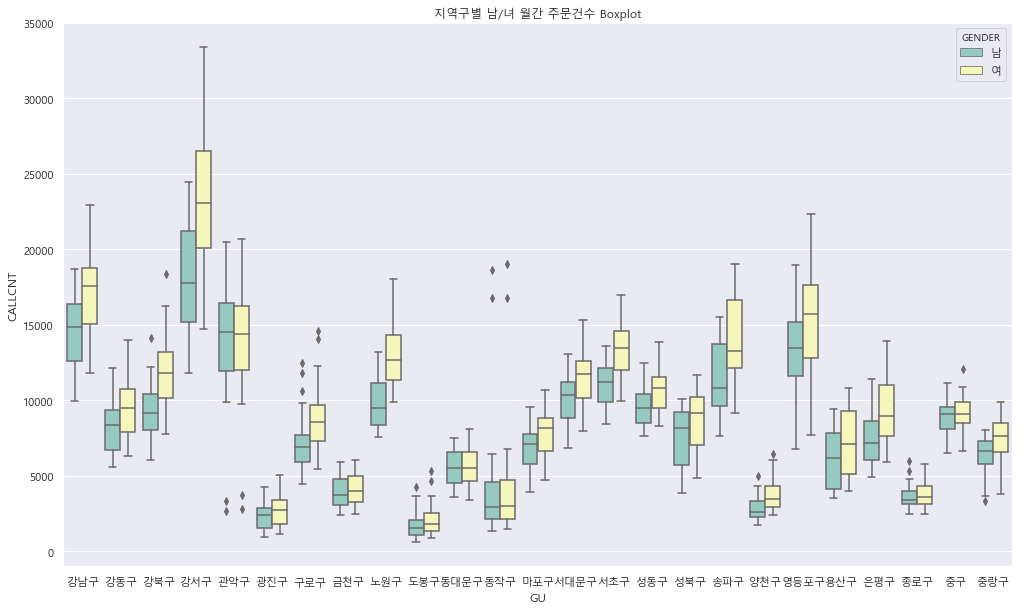

In [56]:
sns.set(rc={'figure.figsize':(17, 10)}, font=fl)
sns.boxplot( x=gu_m_g_sum['GU'], y=gu_m_g_sum['CALLCNT'], hue='GENDER', data=gu_m_g_sum, palette='Set3').set_title("지역구별 남/녀 월간 주문건수 Boxplot")

In [57]:
# 요일별 남/녀 주문건수 합계를 구함
week_gd_df = chCall_df.groupby(['DAYOFWEEK', 'GENDER'], as_index=False)['CALLCNT'].sum()
week_gd_df.head()

,DAYOFWEEK,GENDER,CALLCNT
0,금,남,1098229
1,금,여,1356056
2,목,남,829268
3,목,여,980277
4,수,남,839985


In [58]:
# 요일 데이터 정렬을 위한 카테고리
cat_type = CategoricalDtype(categories=dayOfWeek, ordered=True)
week_gd_df['DAYOFWEEK'] = week_gd_df['DAYOFWEEK'].astype(cat_type)

In [59]:
week_gd_df=week_gd_df.sort_values(['DAYOFWEEK'])
week_gd_df.head()

,DAYOFWEEK,GENDER,CALLCNT
6,월,남,754393
7,월,여,860307
12,화,남,804976
13,화,여,938383
4,수,남,839985


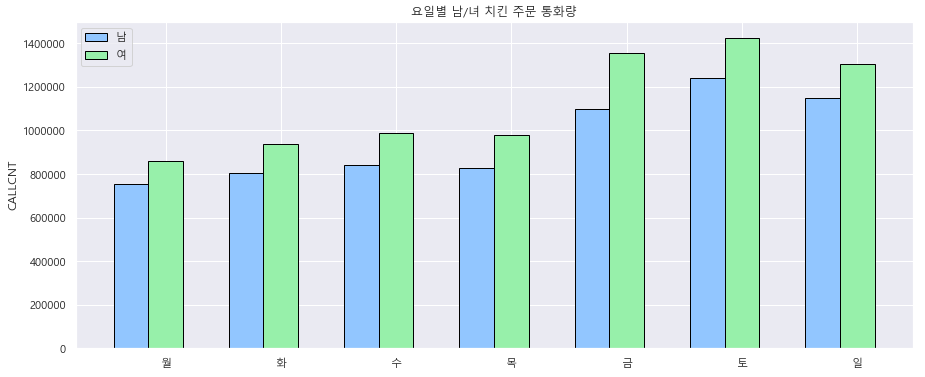

In [60]:
#width of the bars
barWidth=0.3

#Choose the height of the blue blue bars
bars1 = week_gd_df[ week_gd_df["GENDER"]=='남' ]['CALLCNT']
bars2 = week_gd_df[ week_gd_df['GENDER']=='여' ]['CALLCNT']

#The x position of bars
r1 = np.arange( len(bars1) )
r2 = [x + barWidth for x in r1]

#style
plt.style.use('seaborn-pastel')
plt.figure(figsize=(15,6))
plt.rc('font', family=fl)

#create blue bars
plt.bar(r1, bars1, width=barWidth, edgecolor='black', label='남')

#create red bars
plt.bar(r2, bars2, width=barWidth, edgecolor='black', label='여')

#general layout
plt.xticks( [r + barWidth for r in range (len(bars1))], dayOfWeek )
plt.ylabel('CALLCNT')
plt.title('요일별 남/녀 치킨 주문 통화량', fontsize=12)
plt.legend()

#show graphic
plt.show()

- 성별과 주문건수와의 상관관계 분석을 위해 요일과 지역구 데이터와 함께 조회하였음
- 남성에 비해 여성의 주문 수가 많은 것을 확인할 수 있었음

### 3-2-4. 그 외 컬럼과 주문건수와의 연관성 분석

In [61]:
# 년도, 동별로 주문건수를 합함
gd_year_df=chCall_df.groupby(['Y', 'GU_DONG'], as_index=False)['CALLCNT'].sum()

In [62]:
# 연간 주문통화량이 가장 많은 동 Top10
gd_year_df.sort_values(by=['CALLCNT'], ascending=False).head(10)

,Y,GU_DONG,CALLCNT
39,2017,관악구 신림동,275583
351,2018,관악구 신림동,269184
59,2017,노원구 상계동,241593
161,2017,송파구 송파동,233822
129,2017,성동구 성수동2가,227888
21,2017,강북구 미아동,223977
36,2017,강서구 화곡동,212396
453,2018,성동구 성수동2가,211216
28,2017,강서구 내발산동,208512
493,2018,송파구 송파동,207953


In [63]:
# 연령대별 주문통화량 순위
age_df=chCall_df.groupby(['AGE'], as_index=False)['CALLCNT'].sum()
age_df.sort_values(by=['CALLCNT'], ascending=False)

,AGE,CALLCNT
3,40대,4148347
2,30대,3786615
1,20대,2744719
4,50대,1786740
0,10대,1178358
5,60대이상,923322


- 동별로 조회해본 결과 신림동의 주문이 제일 많았음 인구 밀집도가 높은 지역이라 주문 건수가 많은 것으로 추측됨
- 연령대별로 조회하였더니 40대, 30대, 20대 순으로 주문이 많은 것을 확인함, 배달 앱 서비스가 전화 주문건수에 영향을 미친것으로 파악됨

## 3-3. 데이터 처리  
### 3-3-1. 주문건수 데이터 정리

#### ① 통화건수 데이터 범주화하기

- 통화건수 데이터를 상/중/하로 나누기

In [115]:
# 일자, 요일, 성별, 연령, 구별로 Groupby, CALLCNT를 합함
# 모두 같은 값이라 필요없는 컬럼 제외: SIDO(서울특별시), JOB(치킨)
# 데이터 시각화를 위해 생성한 'Y', 'M' 제외
# 경우의 수가 많이 나오는 DONG(380여개) 제외

chCall_df = chCall_df.groupby(['CALLDATE', 'DAYOFWEEK', 'GENDER', 'AGE', 'GU'], as_index=False).sum()
chCall_df.drop(['Y', 'M'], axis=1, inplace=True)
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT
0,2017-01-01,일,남,10대,강남구,37
1,2017-01-01,일,남,10대,강동구,43
2,2017-01-01,일,남,10대,강북구,39
3,2017-01-01,일,남,10대,강서구,55
4,2017-01-01,일,남,10대,관악구,26


In [116]:
chCall_df['CALLCNT'].describe()

count    296612.000000
mean         49.115009
std          46.777546
min           5.000000
25%          18.000000
50%          34.000000
75%          64.000000
max         815.000000
Name: CALLCNT, dtype: float64

(array([2.50013e+05, 3.78030e+04, 6.79200e+03, 1.43600e+03, 3.97000e+02,
        1.25000e+02, 3.30000e+01, 8.00000e+00, 1.00000e+00, 4.00000e+00]),
 array([  5.,  86., 167., 248., 329., 410., 491., 572., 653., 734., 815.]),
 <a list of 10 Patch objects>)

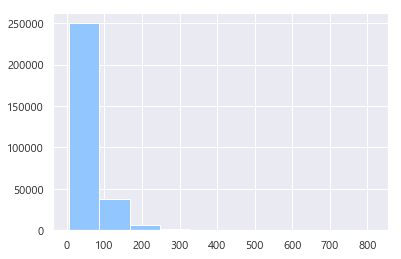

In [87]:
# 통화량 컬럼 시각화
plt.figure(figsize=(6,4))
plt.hist(chCall_df['CALLCNT'])

(array([46999., 55061., 43994., 28972., 24967., 17726., 15681., 11233.,
        10226.,  8105.]),
 array([  5. ,  14.5,  24. ,  33.5,  43. ,  52.5,  62. ,  71.5,  81. ,
         90.5, 100. ]),
 <a list of 10 Patch objects>)

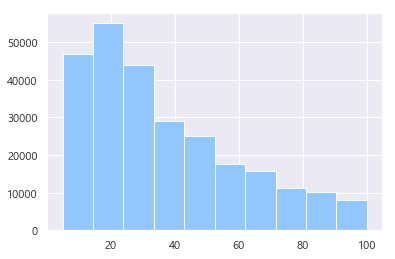

In [88]:
# 통화량 컬럼 시각화 (callcnt 100건 이하인 것만 추려서)
plt.figure(figsize=(6,4))
plt.hist(chCall_df['CALLCNT'][chCall_df['CALLCNT']<=100])

In [117]:
call_cnt=np.array(chCall_df['CALLCNT'])
call_cnt

array([37, 43, 39, ..., 10, 17,  5], dtype=int64)

In [118]:
# 통화량을 백분위수로 정렬하여 1/3 단위로 쪼갬
# 하위 33%
LOW_LEVEL = np.percentile(call_cnt, 33)

In [119]:
# 33~66%
MIDDLE_LEVEL = np.percentile(call_cnt, 66)

In [120]:
#통화건수에 따라 상/중/하로 나눠주기
level_list=[]
for cnt in call_cnt:
    if (LOW_LEVEL >= cnt ):
        level = '하'
    elif ( MIDDLE_LEVEL >= cnt ):
        level = '중'
    else:
        level = '상'
    
    level_list.append(level)

In [121]:
# 상/중/하로 나눈 데이터의 값의 분포를 확인
print(level_list.count('상'))
print(level_list.count('중'))
print(level_list.count('하'))

98826
95726
102060


In [122]:
# 통화건수에 따라 상/중/하로 치환한 값을 chCall_df['CALLCNT']에 대입
chCall_df['CALLCNT'] = level_list

In [123]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT
0,2017-01-01,일,남,10대,강남구,중
1,2017-01-01,일,남,10대,강동구,중
2,2017-01-01,일,남,10대,강북구,중
3,2017-01-01,일,남,10대,강서구,상
4,2017-01-01,일,남,10대,관악구,중


#### ② 통화건수, 날씨 데이터 프레임 병합

In [124]:
weather_df = pd.read_csv('C:/ai/workspace/module_project02/weather_df.csv')

In [125]:
weather_df.head()

,일시,평균기온(°C),일강수량(mm)
0,2017-01-01,2.7,0.0
1,2017-01-02,5.0,0.3
2,2017-01-03,2.0,0.0
3,2017-01-04,3.9,0.0
4,2017-01-05,3.8,0.0


In [126]:
# weather_df에 '일시' 컬럼의 데이터 포맷을 str > date 형식으로 변환
weather_df['일시'] = pd.to_datetime(weather_df['일시'].astype(str), format="%Y-%m-%d")

In [127]:
# 통화건수 DataFrame과 날씨 DataFrame merge
chCall_df=pd.merge(chCall_df, weather_df, left_on='CALLDATE', right_on='일시')

In [128]:
# 중복값인 '일시' 컬럼 삭제
del( chCall_df['일시'] )

In [129]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm)
0,2017-01-01,일,남,10대,강남구,중,2.7,0.0
1,2017-01-01,일,남,10대,강동구,중,2.7,0.0
2,2017-01-01,일,남,10대,강북구,중,2.7,0.0
3,2017-01-01,일,남,10대,강서구,상,2.7,0.0
4,2017-01-01,일,남,10대,관악구,중,2.7,0.0


#### ③ 축구 경기 데이터프레임 병합

In [130]:
kf_df = pd.read_csv('c:/ai/workspace/module_project02/kfootball_plan.csv')

In [131]:
# 2019-9-30일 이후 데이터 삭제
kf_df = kf_df.loc[0:85]

In [132]:
# kf_df에 'yeardate' 컬럼의 데이터 포맷을 str > date 형식으로 변환
kf_df['yeardate'] = pd.to_datetime(kf_df['yeardate'].astype(str), format="%Y%m%d")

In [133]:
kf_df.head()

,yeardate,yoil,sigan,country,label
0,2017-01-11,목,20:30,대한민국 2 승리팀 베트남 1,국가대표
1,2017-01-14,일,20:30,대한민국 0 시리아 0,국가대표
2,2017-01-17,수,20:30,대한민국 3 승리팀 호주 2,국가대표
3,2017-01-20,토,17:00,대한민국 2 승리팀 말레이시아 1,국가대표
4,2017-01-23,화,20:30,대한민국 1 우즈베키스탄 4 승리팀,국가대표


In [134]:
# 같은 날 경기가 2개 이상 있는 경우를 확인하기 위한 'Game_Count' 컬럼 추가
kf_df['game_count'] = np.nan

In [135]:
# .duplicated('yeardate'): 'yeardate'(날짜데이터) 컬럼에 동일한 값이 있는지를 검사하는 함수 정의
def set_game_count(index):    
    if kf_df.duplicated('yeardate')[index] == False:
        return 1
    else:
        return 2

In [136]:
kf_df['game_count'] = kf_df['game_count'].index.map(set_game_count)

In [137]:
kf_df.head()

,yeardate,yoil,sigan,country,label,game_count
0,2017-01-11,목,20:30,대한민국 2 승리팀 베트남 1,국가대표,1
1,2017-01-14,일,20:30,대한민국 0 시리아 0,국가대표,1
2,2017-01-17,수,20:30,대한민국 3 승리팀 호주 2,국가대표,1
3,2017-01-20,토,17:00,대한민국 2 승리팀 말레이시아 1,국가대표,1
4,2017-01-23,화,20:30,대한민국 1 우즈베키스탄 4 승리팀,국가대표,1


In [33]:
day_two_game = kf_df[ kf_df['game_count']==2 ]

In [34]:
day_two_game

,yeardate,yoil,sigan,country,label,game_count
74,2019-06-01,토,03:30,대한민국 2 승리팀 아르헨티나 1,청소년대표,2
81,2019-06-12,수,22:00,대한민국 0 나이지리아 2 승리팀,국가대표,2


In [138]:
# 데이터 병합을 위해 날짜 데이터가 중복인 행들은 삭제함
dup_index=kf_df[ kf_df['game_count']== 2 ].index
kf_df=kf_df.drop(dup_index)

In [139]:
# 통화건수 DataFrame과 축구경기일정 DataFrame merge
chCall_df=pd.merge(chCall_df, kf_df, left_on='CALLDATE', right_on='yeardate', how='left')

In [140]:
# 데이터 프레임에서 game_count를 제외한 컬럼 삭제
chCall_df.drop(['yeardate', 'yoil', 'sigan', 'country', 'label'], axis=1, inplace=True)

In [142]:
# 'game_count'컬럼에 NaN 값을 0로 바꿔줌
chCall_df['game_count'].fillna(0, inplace=True)

In [143]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,일,남,10대,강남구,중,2.7,0.0,0.0
1,2017-01-01,일,남,10대,강동구,중,2.7,0.0,0.0
2,2017-01-01,일,남,10대,강북구,중,2.7,0.0,0.0
3,2017-01-01,일,남,10대,강서구,상,2.7,0.0,0.0
4,2017-01-01,일,남,10대,관악구,중,2.7,0.0,0.0


### 3-3-2. 데이터 전처리 하기: 요일, 성별, 연령, 구(혹은 구동)

#### ① 데이터 전처리 (1): 요일

[(0, '일'), (1, '월'), (2, '화'), (3, '수'), (4, '목'), (5, '금'), (6, '토')]

In [144]:
chCall_df['DAYOFWEEK'].unique()

array(['일', '월', '화', '수', '목', '금', '토'], dtype=object)

In [145]:
#데이터 앞에 인덱스를 붙여줌
list(enumerate(chCall_df['DAYOFWEEK'].unique()))

[(0, '일'), (1, '월'), (2, '화'), (3, '수'), (4, '목'), (5, '금'), (6, '토')]

In [146]:
# 인덱스와 데이터를 출력
for data in enumerate(chCall_df['DAYOFWEEK'].unique()):
    print('index:', data[0], ",data:", data[1])

index: 0 ,data: 일
index: 1 ,data: 월
index: 2 ,data: 화
index: 3 ,data: 수
index: 4 ,data: 목
index: 5 ,data: 금
index: 6 ,data: 토


In [147]:
# DAYOFWEEK 컬럼의 데이터를 숫자로 변환
for data in enumerate(chCall_df['DAYOFWEEK'].unique()):
    chCall_df['DAYOFWEEK'].replace(data[1], data[0], inplace=True)

In [148]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,남,10대,강남구,중,2.7,0.0,0.0
1,2017-01-01,0,남,10대,강동구,중,2.7,0.0,0.0
2,2017-01-01,0,남,10대,강북구,중,2.7,0.0,0.0
3,2017-01-01,0,남,10대,강서구,상,2.7,0.0,0.0
4,2017-01-01,0,남,10대,관악구,중,2.7,0.0,0.0


#### ② 데이터 전처리 (2): 성별

[(0, '여'), (1, '남')]

In [149]:
chCall_df['GENDER'].unique()

array(['남', '여'], dtype=object)

In [150]:
for data in enumerate(chCall_df['GENDER'].unique()):
    chCall_df['GENDER'].replace(data[1], data[0], inplace=True)

In [151]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,0,10대,강남구,중,2.7,0.0,0.0
1,2017-01-01,0,0,10대,강동구,중,2.7,0.0,0.0
2,2017-01-01,0,0,10대,강북구,중,2.7,0.0,0.0
3,2017-01-01,0,0,10대,강서구,상,2.7,0.0,0.0
4,2017-01-01,0,0,10대,관악구,중,2.7,0.0,0.0


#### ③ 데이터 전처리 (3): 연령

10대 : 1, 20대: 2, 30대: 3, 40대: 4, 50대: 5, 60대이상: 6

In [152]:
chCall_df['AGE'].unique()

array(['10대', '20대', '30대', '40대', '50대', '60대이상'], dtype=object)

In [153]:
# "AGE"컬럼 값에서 문자열 제거
tmp_list=[]
for data in chCall_df['AGE']:
    if data == "60대이상":
        data = data.replace('대이상', '') ##### str > int로 변경해야함!!!
    else:
        data = data.replace('대', '')
    tmp_list.append(data)

In [154]:
# 나이를 10으로 나눈 몫 계산하는 함수 정의
def category_age(age):
    return age//10

In [155]:
# 각 값에서 문자를 제거한 tmp_list값을 chCall_df['AGE']에 대입
chCall_df['AGE'] = tmp_list
# chCall_df['AGE'] type을 int로 변경
chCall_df['AGE'] = pd.to_numeric(chCall_df['AGE'])
# 컬럼.apply(함수): 컬럼의 각 데이터마다 함수를 실행해서 결과를 리턴
chCall_df['AGE'] = chCall_df['AGE'].apply(category_age)

In [156]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,0,1,강남구,중,2.7,0.0,0.0
1,2017-01-01,0,0,1,강동구,중,2.7,0.0,0.0
2,2017-01-01,0,0,1,강북구,중,2.7,0.0,0.0
3,2017-01-01,0,0,1,강서구,상,2.7,0.0,0.0
4,2017-01-01,0,0,1,관악구,중,2.7,0.0,0.0


#### ④ 데이터 전처리 (4): 구 데이터

(0, '강남구'), (1, '강동구'), (2, '강북구'), (3, '강서구'), (4, '관악구'), (5, '광진구'),
(6, '구로구'), (7, '금천구'), (8, '노원구'), (9, '도봉구'), (10, '동대문구'), (11, '동작구'),
(12, '마포구'), (13, '서대문구'), (14, '서초구'), (15, '성동구'), (16, '성북구'), (17, '송파구'),
(18, '양천구'), (19, '영등포구'), (20, '용산구'), (21, '은평구'), (22, '종로구'), (23, '중구'), (24, '중랑구')

In [157]:
list(enumerate(chCall_df['GU'].unique()))

[(0, '강남구'),
 (1, '강동구'),
 (2, '강북구'),
 (3, '강서구'),
 (4, '관악구'),
 (5, '광진구'),
 (6, '구로구'),
 (7, '금천구'),
 (8, '노원구'),
 (9, '도봉구'),
 (10, '동대문구'),
 (11, '동작구'),
 (12, '마포구'),
 (13, '서대문구'),
 (14, '서초구'),
 (15, '성동구'),
 (16, '성북구'),
 (17, '송파구'),
 (18, '양천구'),
 (19, '영등포구'),
 (20, '용산구'),
 (21, '은평구'),
 (22, '종로구'),
 (23, '중구'),
 (24, '중랑구')]

In [158]:
for data in enumerate((chCall_df['GU'].unique())):
    chCall_df['GU'].replace(data[1], data[0], inplace=True)

In [159]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,0,1,0,중,2.7,0.0,0.0
1,2017-01-01,0,0,1,1,중,2.7,0.0,0.0
2,2017-01-01,0,0,1,2,중,2.7,0.0,0.0
3,2017-01-01,0,0,1,3,상,2.7,0.0,0.0
4,2017-01-01,0,0,1,4,중,2.7,0.0,0.0


#### ⑤ 데이터 전처리 (5): 기온

-5도 이하: 0, -4~5도: 1, 6~15도: 2, 16~25도: 3, 26도 이상: 4

(array([ 2684., 11332., 29725., 32348., 35216., 27495., 35791., 60997.,
        46228., 14796.]),
 array([-14.8 ,  -9.95,  -5.1 ,  -0.25,   4.6 ,   9.45,  14.3 ,  19.15,
         24.  ,  28.85,  33.7 ]),
 <a list of 10 Patch objects>)

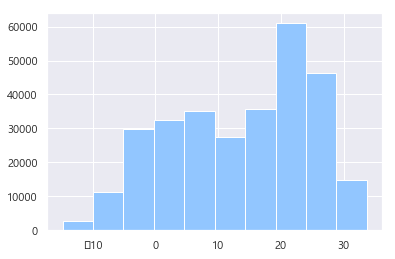

In [160]:
# 평균 기온 컬럼 시각화
plt.figure(figsize=(6,4))
plt.hist(chCall_df['평균기온(°C)'])

In [161]:
#### 방법1) 범위를 지정하여 범주화 처리
temper_list=[]
for data in chCall_df['평균기온(°C)']:
    if (data <= -5) :
        temper = 0
    elif (data <= 5):
        temper = 1
    elif (data <= 15):
        temper = 2
    elif (data <= 25):
        temper = 3
    else:
        temper = 4
                
    temper_list.append(temper)

In [162]:
# 범주화 한 값의 분포를 확인
print(temper_list.count(0))
print(temper_list.count(1))
print(temper_list.count(2))
print(temper_list.count(3))
print(temper_list.count(4))

14612
66234
65063
102044
48659


In [163]:
chCall_df['평균기온(°C)'] = temper_list

#### ⑥ 데이터 전처리 (6): 강수량

- 강수량 0.0 : 0,
- 강수량 0 초과 : 1

(array([278873.,   7977.,   4141.,    885.,   2350.,    593.,    894.,
             0.,    300.,    599.]),
 array([  0.  ,  14.45,  28.9 ,  43.35,  57.8 ,  72.25,  86.7 , 101.15,
        115.6 , 130.05, 144.5 ]),
 <a list of 10 Patch objects>)

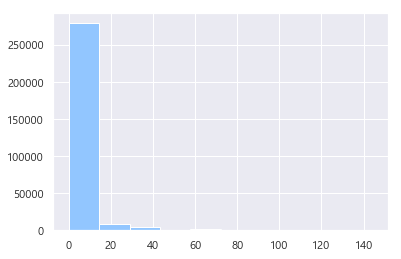

In [164]:
# 강수량 컬럼 시각화
plt.figure(figsize=(6,4))
plt.hist(chCall_df['일강수량(mm)'])

(array([245752.,  11266.,   8616.,   6478.,   3520.,   1477.,   1174.,
          1485.,   2060.,   1774.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

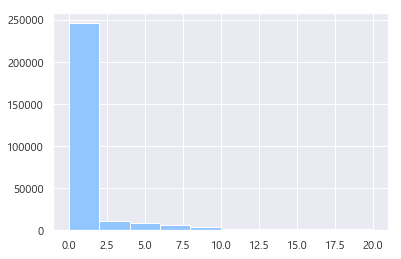

In [166]:
# 강수량 컬럼 시각화 (20mm 이하인것만)
plt.figure(figsize=(6,4))
plt.hist(chCall_df['일강수량(mm)'][chCall_df['일강수량(mm)']<=20])

In [69]:
chCall_df['일강수량(mm)'].describe()

count    296612.000000
mean          3.244330
std          12.577845
min           0.000000
25%           0.000000
50%           0.000000
75%           0.300000
max         144.500000
Name: 일강수량(mm), dtype: float64

In [167]:
tmp_rain=np.array(chCall_df['일강수량(mm)'])

In [168]:
np.percentile(tmp_rain, 50)

0.0

In [169]:
rain_list=[]
for data in chCall_df['일강수량(mm)']:
    if data == 0:
        rain=0
    else:
        rain=1
                
    rain_list.append(rain)

In [170]:
print(rain_list.count(0))
print(rain_list.count(1))

214393
82219


In [171]:
chCall_df['일강수량(mm)'] = rain_list

In [172]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,0,1,0,중,1,0,0.0
1,2017-01-01,0,0,1,1,중,1,0,0.0
2,2017-01-01,0,0,1,2,중,1,0,0.0
3,2017-01-01,0,0,1,3,상,1,0,0.0
4,2017-01-01,0,0,1,4,중,1,0,0.0


#### ⑦ 데이터 전처리 (7): 통화건수

상:2, 중:1, 하:0

In [173]:
chCall_df['CALLCNT'].unique()

array(['중', '상', '하'], dtype=object)

In [174]:
list(enumerate(chCall_df['CALLCNT'].unique()))

[(0, '중'), (1, '상'), (2, '하')]

In [175]:
# 값들의 순서에 따라 의미를 부여하기 위해 상/중/하 값이 순서대로 들어갈 수 있게 함수 정의
# 상:2, 중:1, 하:0
level_list=[]
for data in chCall_df['CALLCNT']:
    if (data == '하') :
        level = 0
    elif (data == '중'):
        level = 1
    else:
        level = 2
                
    level_list.append(level)

In [176]:
chCall_df['CALLCNT'] = level_list

In [177]:
chCall_df.head()

,CALLDATE,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,평균기온(°C),일강수량(mm),game_count
0,2017-01-01,0,0,1,0,1,1,0,0.0
1,2017-01-01,0,0,1,1,1,1,0,0.0
2,2017-01-01,0,0,1,2,1,1,0,0.0
3,2017-01-01,0,0,1,3,2,1,0,0.0
4,2017-01-01,0,0,1,4,1,1,0,0.0


In [178]:
# 컬럼의 값을 영문로 바꿔줌
chCall_df.rename(columns={'평균기온(°C)':'Temperature', '일강수량(mm)':'Rainfall'}, inplace=True)

In [179]:
# 일자 컬럼은 삭제
del(chCall_df['CALLDATE'])

In [180]:
chCall_df.head()

,DAYOFWEEK,GENDER,AGE,GU,CALLCNT,Temperature,Rainfall,game_count
0,0,0,1,0,1,1,0,0.0
1,0,0,1,1,1,1,0,0.0
2,0,0,1,2,1,1,0,0.0
3,0,0,1,3,2,1,0,0.0
4,0,0,1,4,1,1,0,0.0


In [84]:
chCall_df.to_csv('C:/ai/workspace/Module_project02/chCall_df.csv',
           sep=',',
           index=False
           )

#### ⑧ 날씨 및 축구경기와 주문건수의 상관관계 확인

In [181]:
pd.crosstab(chCall_df['Temperature'], chCall_df['CALLCNT'], margins=True)

CALLCNT,0,1,2,All
Temperature,,,,
0,3960,4666,5986,14612
1,20532,21784,23918,66234
2,22933,20846,21284,65063
3,37076,32601,32367,102044
4,17559,15829,15271,48659
All,102060,95726,98826,296612


In [182]:
pd.crosstab(chCall_df['Rainfall'], chCall_df['CALLCNT'], margins=True)

CALLCNT,0,1,2,All
Rainfall,,,,
0,74141,69157,71095,214393
1,27919,26569,27731,82219
All,102060,95726,98826,296612


In [183]:
pd.crosstab(chCall_df['game_count'], chCall_df['CALLCNT'], margins=True)

CALLCNT,0,1,2,All
game_count,,,,
0.0,94210,87632,90108,271950
1.0,7850,8094,8718,24662
All,102060,95726,98826,296612


## 3-4. 의사결정트리 만들기

### 3-4-1. 분류

In [184]:
# 예측하고자 하는 'CALLCNT' 컬럼을 y_label 컬럼에 대입
y_label = chCall_df['CALLCNT']

In [185]:
# chCall_df에서 'CALLCNT' 컬럼 삭제
chCall_df.drop('CALLCNT', axis=1, inplace=True)

In [186]:
y_label.head()

0    1
1    1
2    1
3    2
4    1
Name: CALLCNT, dtype: int64

In [187]:
chCall_df.head()

,DAYOFWEEK,GENDER,AGE,GU,Temperature,Rainfall,game_count
0,0,0,1,0,1,0,0.0
1,0,0,1,1,1,0,0.0
2,0,0,1,2,1,0,0.0
3,0,0,1,3,1,0,0.0
4,0,0,1,4,1,0,0.0


### 3-4-2. 의사결정트리 ① : 지역구와 날씨

In [188]:
# 구와 날씨 정보만 가진 데이터 프레임 생성
wd_df = chCall_df.drop(['DAYOFWEEK', 'GENDER', 'AGE', 'game_count'], axis=1)
wd_df.head()

,GU,Temperature,Rainfall
0,0,1,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [189]:
# 학습용 데이터와 테스트용 데이터 추출
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(wd_df, y_label)

In [191]:
dt_clf_w = DecisionTreeClassifier()

In [192]:
dt_clf_w

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [193]:
# 의사 결정 트리를 이용한 학습
dt_clf_w = dt_clf_w.fit(X_train_w, y_train_w)

In [194]:
# 테스트 데이터 예측
dt_prediction_w = dt_clf_w.predict(X_test_w)

In [195]:
# 예측 테이터 출력
dt_prediction_w

array([2, 0, 0, ..., 2, 1, 0], dtype=int64)

In [197]:
# 살제 데이터 출력
y_test_w.head()

104814    1
221029    0
184412    0
121263    2
59176     2
Name: CALLCNT, dtype: int64

In [199]:
confusion_matrix(y_test_w, dt_prediction_w)

array([[14406,  5811,  5286],
       [ 5617,  7571, 10784],
       [ 1182,  5828, 17668]], dtype=int64)

In [200]:
# 의사결정트리의 정확도 출력
accuracy = accuracy_score(y_test_w, dt_prediction_w)

In [201]:
print("정확도: ", accuracy)

정확도:  0.5346378433778809


### 3-4-3. 의사결정트리 ② : 지역구와 축구경기 

In [202]:
fgame_df = chCall_df.drop(['DAYOFWEEK', 'GENDER', 'AGE', 'Temperature', 'Rainfall'], axis=1)
fgame_df.head()

,GU,game_count
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [203]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(fgame_df, y_label)

In [204]:
dt_clf_f = DecisionTreeClassifier()

In [205]:
dt_clf_f

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [206]:
dt_clf_f = dt_clf_f.fit(X_train_f, y_train_f)

In [207]:
dt_prediction_f= dt_clf_f.predict(X_test_f)

In [208]:
dt_prediction_f

array([2, 1, 0, ..., 2, 2, 2], dtype=int64)

In [209]:
y_test_f.head()

5398      2
203004    0
225506    0
66582     2
156165    1
Name: CALLCNT, dtype: int64

In [210]:
confusion_matrix(y_test_f, dt_prediction_f)

array([[13863,  6368,  5369],
       [ 5232,  7814, 10789],
       [  950,  6122, 17646]], dtype=int64)

In [211]:
accuracy = accuracy_score(y_test_f, dt_prediction_f)
print("정확도:", accuracy)

정확도: 0.5302954701765269


### 3-4-4. 종합 의사결정트리 생성

In [212]:
chCall_df.head()

,DAYOFWEEK,GENDER,AGE,GU,Temperature,Rainfall,game_count
0,0,0,1,0,1,0,0.0
1,0,0,1,1,1,0,0.0
2,0,0,1,2,1,0,0.0
3,0,0,1,3,1,0,0.0
4,0,0,1,4,1,0,0.0


In [216]:
X_train, X_test, y_train, y_test = train_test_split(chCall_df, y_label)

In [225]:
dt_clf = DecisionTreeClassifier()

In [226]:
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [227]:
dt_clf=dt_clf.fit(X_train, y_train)

In [228]:
dt_prediction = dt_clf.predict(X_test)

In [229]:
dt_prediction

array([1, 2, 0, ..., 1, 1, 0], dtype=int64)

In [230]:
y_test.head()

288496    0
35167     2
130107    0
244270    2
35532     2
Name: CALLCNT, dtype: int64

In [231]:
confusion_matrix(y_test, dt_prediction)

array([[20963,  4419,   194],
       [ 5762, 14657,  3302],
       [  261,  4335, 20260]], dtype=int64)

In [232]:
accuracy = accuracy_score(y_test, dt_prediction)
print("정확도:", accuracy)

정확도: 0.7535770636386929


In [240]:
# 의사결정트리 시각화 이미지 출력을 위한 의사결정트리 생성 (max_depth=5)

dt_clf_2 = DecisionTreeClassifier(max_depth=5)
dt_clf_2 = dt_clf_2.fit(X_train, y_train)
dt_prediction_2 = dt_clf_2.predict(X_test)
accuracy_2 = accuracy_score(y_test, dt_prediction_2)
print("정확도:", accuracy_2)

정확도: 0.6284708642940946


### 3-4-5. 의사결정트리 시각화

In [236]:
os.environ['PATH']+=os.pathsep+"C:/ai/program/Graphviz/bin"

In [238]:
# 컬럼 이름의 리스트 리턴
feature_names = chCall_df.columns.tolist()
feature_names

['DAYOFWEEK', 'GENDER', 'AGE', 'GU', 'Temperature', 'Rainfall', 'game_count']

In [239]:
# 결과의 이름 설정
target_name = np.array(['Low', 'Middle', 'Top'])
target_name

array(['Low', 'Middle', 'Top'], dtype='<U6')

In [241]:
# 트리를 그래프로 그림
dt_dot_data = tree.export_graphviz(dt_clf_2, out_file=None,
                                  feature_names=feature_names,
                                  class_names=target_name,
                                  filled=True, rounded=True,
                                  special_characters=True)

In [243]:
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

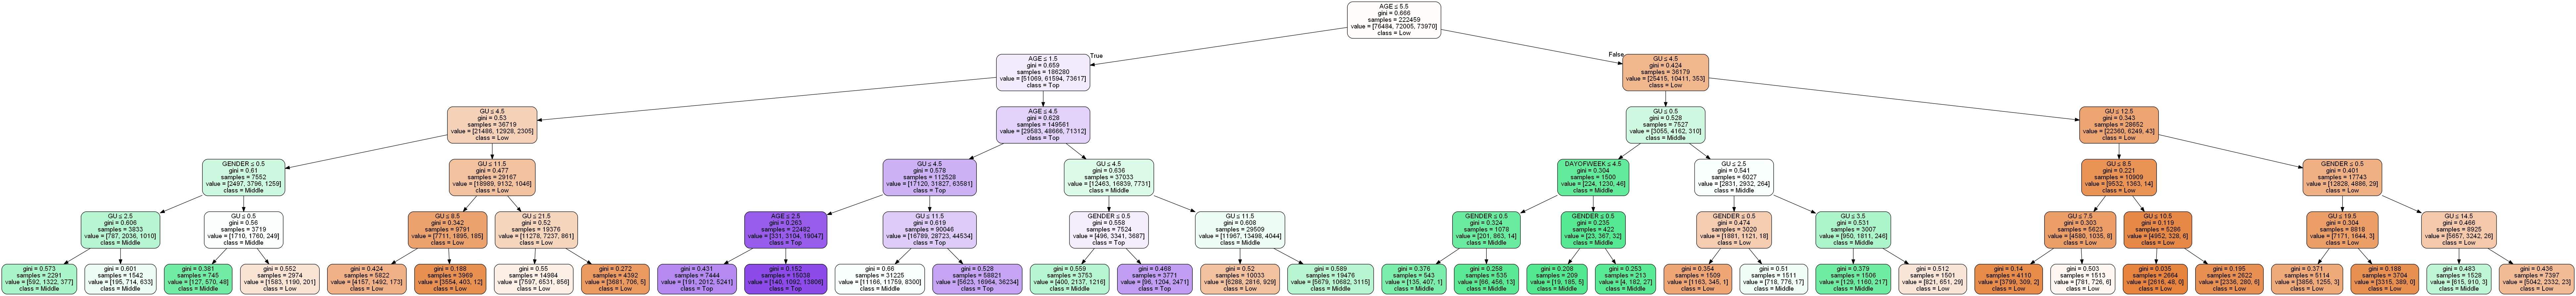

In [244]:
Image(dt_graph.create_png())

In [173]:
dt_graph.write_pdf("chickenCall.pdf")

True

## 3-5. 주문건수 예측하기

- Flask를 이용해 치킨 주문건수 예측 웹서비스 제작(Bootstrap Template 사용)

In [ ]:
from flask import Flask, flash, redirect, escape, request, render_template, url_for
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

app = Flask(__name__)
app.secret_key = "super secret key"

@app.route('/')
def index():    
    return render_template('index.html')

# Form에서 입력받은 데이터를 가공해서 결과를 전달해줌
@app.route('/result', methods=['GET', 'POST'])
def result():

    dayofweek=request.form.get('dayofweek')
    gender=request.form.get('gender')
    age=request.form.get('age')
    gu=request.form.get('gu')
    temperature = request.form.get('Temperature')
    rainfall = request.form.get('Rainfall')
    game_count = request.form.get('game_count')

    # 모두 char형인 값들을 int, float형으로 바꿔줘야함
    dayofweek = int(dayofweek)
    gender = int(gender)
    age = int(age)
    gu = int(gu)
    temperature = float(temperature)
    rainfall = round(float(rainfall), 2)
    game_count = int(game_count)
    
    # 의사결정트리 함수에 입력값 전달
    result_value = decision_tree(dayofweek, gender, age, gu, temperature, rainfall, game_count)
    
    # 결과값에 따라 노출할 메세지 전달 
    # 주문 건수 예측 결과값: 하
    if result_value == 0:
        message = "오늘은 주문이 저조할 것 같습니다 T.T"
    
    # 주문 건수 예측 결과값: 중
    elif result_value == 1:
        message = "오늘은 평소처럼 준비하시면 되겠습니다! :)"
    
    # 주문 건수 예측 결과값: 상
    else:
        message = "오늘은 주문이 많겠네요! 미리 대비해주세요! :D"

    return render_template('result.html', message=message)    


# 의사결정트리를 생성하고 유저가 입력한 값을 받아 예측한 결과값을 전달
def decision_tree(dayofweek, gender, age, gu, temperature, rainfall, game_count):
    # 의사결정트리 생성
    chCall_df = pd.read_csv("C:/ai/workspace/Module_project02/decision_tree_table.csv")
    y_label = chCall_df['CALLCNT']
    chCall_df.drop('CALLCNT', axis=1, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(chCall_df, y_label)
    dt_clf = DecisionTreeClassifier()
    dt_clf=dt_clf.fit(X_train, y_train)
    dt_prediction = dt_clf.predict(X_test)
    
    # 유저가 입력한 값을 전달받아 np.array로 변환
    new_data = np.array([[dayofweek, gender, age, gu, temperature, rainfall, game_count]])
    predict_value = dt_clf.predict(new_data)
    return predict_value

# result 페이지에서 홈버튼을 눌렀을 시 index 페이지로 이동
@app.route('/go_home')
def go_home():    
    return redirect(url_for('index'))

# python app.py로 실행
if __name__ == '__main__':
    app.run(debug=True) 

#### 치킨 주문건수 예측 웹서비스 예시 이미지

데이터 예측에 사용되는 컬럼들의 정보를 입력하면 예측한 결과값에 따라 메세지를 출력할 수 있도록 구성

![](flask_predict_webservice.png)

**예측 결과 페이지 예시 이미지**

![](flask_predict_webservice_result.png)

# 4. 결과 및 보완점


## 4-1. 프로젝트 결과

- 프로젝트를 통해 치킨 배달 주문건수에 영향을 미치는 다양한 요인들이 있는 것을 확인할 수 있었음.
- 하지만 예상했던 것과는 달리 날씨 및 축구경기와 주문건수의 뚜렷한 상호관계는 찾기 힘들었음. 
- 주문건수에 영향을 미칠 수 있는 요인들을 세분화하거나 그 외의 요인들을 찾아내서 데이터 컬럼에 추가했어야 했는데 그 점이 미흡했던 것으로 추측


## 4-2. 프로젝트 보완점

- 날씨 및 축구경기와 주문건수와의 상관관계를 시각화를 통해 파악
- 지역구 데이터를 평행 축으로 분할, 날씨에 영향을 미치는 요소 ( 미세먼지, 풍향, 적설량(지표면에 쌓인 눈의 깊이), 습도 등)을 데이터에 추가해서 분석
- 의사결정트리 생성과 관련된 속성들을 변경하여 트리 생성

# 5. 프로젝트 후기